In [8]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import importlib
import sys
import time

keras = tf.keras
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [515]:
from euler_self_tf import euler_self_tlist, euler_sde
importlib.reload(sys.modules['euler_self_tf'])
import models as md
importlib.reload(sys.modules['models'])
import training as tr
importlib.reload(sys.modules['training'])

<module 'training' from '/Users/rowanbrackston/Box Sync/GitRepos/NN-control/minimal_neural_ode/training.py'>

# Perturbed oscillator as neural SDE (no control yet)

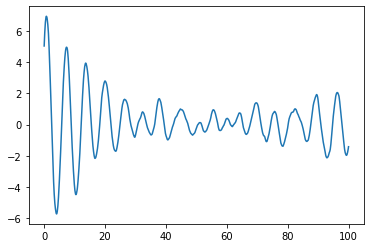

In [6]:
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5.], [5.]], tf.float32)

free_trajectory = euler_sde(md.oscillator_sde(), y0_free, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])
free_trajectory.shape

plt.plot(t_free,free_trajectory)
plt.show()

# Oscillator with linear controller

In [482]:
# Oscillator with controller defined by linear matrix multiplication
class odeModel_oscillator_control(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        self.k = tf.cast([[0, 0],[-23, -10]],tf.float32)
        
    def forward(self, t, y):
        free = tf.matmul(self.A, y)
        con = tf.matmul(self.k, y)
        dy = tf.add(free, con)
        return (dy, tf.cast([[0.0],[0.5]],tf.float32))

6.022885608006618


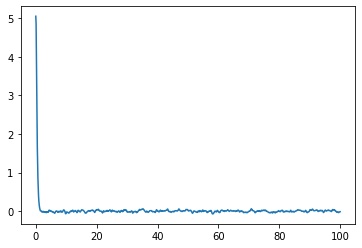

In [483]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]], tf.float32)

t1 = time.perf_counter()
trajectory = euler_sde(odeModel_oscillator_control(), y0, t_grid, 1e-2)
t2 = time.perf_counter()
print(t2-t1)
y = np.concatenate(trajectory[:,0])
ydot = np.concatenate(trajectory[:,1])
trajectory.shape

# plt.plot(t_grid,free_trajectory, t_grid,y)
plt.plot(t_grid,y)
plt.show()

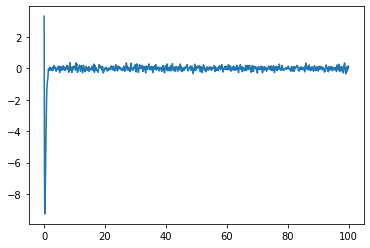

In [35]:
plt.plot(t_grid,ydot)
plt.show()

# Oscillator with NN controller

In [ ]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]],tf.float32)
y0 = [y0,y0,y0]

# Run forward evaluation
t1 = time.perf_counter()
trajectory = euler_sde(md.oscillator_linear_control_sde(), y0, t_grid, 1e-2)
t2 = time.perf_counter()
print(t2-t1)
print(tf.shape(trajectory))
traj1 = np.concatenate(trajectory[:,0,0])
traj2 = np.concatenate(trajectory[:,1,0])
traj3 = np.concatenate(trajectory[:,2,0])

plt.plot(t_free,free_trajectory, t_grid,traj1, t_grid,traj2, t_grid,traj3)

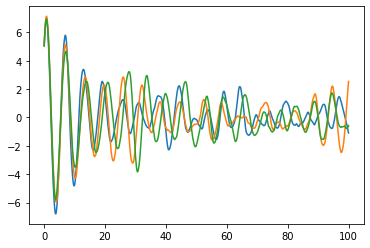

In [145]:
plt.plot(t_grid,traj1, t_grid,traj2, t_grid,traj3)

In [92]:
btch = tf.reshape([y0,y0,y0], [-1,2,1])
tf.tile(tf.cast([[[0.0],[0.5]]],tf.float32),[tf.shape(btch)[0],1,1])

<tf.Tensor: id=7419849, shape=(3, 2, 1), dtype=float32, numpy=
array([[[0. ],
        [0.5]],

       [[0. ],
        [0.5]],

       [[0. ],
        [0.5]]], dtype=float32)>

In [104]:
y_points = euler_sde(model, batch_y0, t_grid, 1e-1)
tf.shape(y_points)
loss = tf.reduce_mean(tf.math.square(y_points), axis=0) # Across time
loss = tf.reduce_mean(loss, axis=0)
loss[0]

<tf.Tensor: id=8706396, shape=(1,), dtype=float32, numpy=array([0.30678344], dtype=float32)>

# Train

In [97]:
def get_batch(batch_size):
    return tf.random_uniform([batch_size,2,1], minval=-15.,maxval=15.)

In [583]:
# Function for gradient evaluation and update
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.5)
# optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

def compute_gradients_and_update_path(batch_y0):
    with tf.GradientTape() as g:
        
        y_points = euler_sde(model, batch_y0, t_grid, 1e-1)
        # y_points = y_points[:,0,1,0]*tf.sign(y_points[:,0,0,0])
        # loss = tf.reduce_mean(y_points)
        loss = tf.reduce_mean(tf.math.square(y_points), axis=0) # Across time
        loss = tf.reduce_mean(loss, axis=0) # Across batches
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

# compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # May make the code faster

In [584]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)
y0 = tf.cast([[0.], [0.]],tf.float32)

# Free system for comparison
free_trajectory = euler_sde(md.oscillator_sde(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
# model = md.oscillator_NNcontrol_sde()
model = md.oscillator_linear_control_sde()
loss_history = []

tf.Tensor([2.5833616], shape=(1,), dtype=float32)


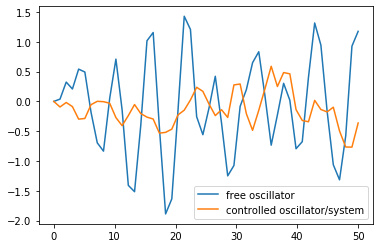

tf.Tensor([0.09589489], shape=(1,), dtype=float32)


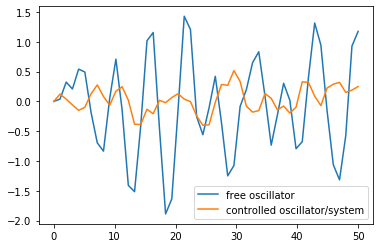

In [585]:
batch_size = 2
niters = 20
test_freq = 20

# Run simulation niters times, updating parameters on each iteration
y0 = tf.cast([[[0.], [0.]]],tf.float32)
for step in range(niters+1):
    
    # batch_y0 = get_batch(batch_size) # Random
    batch_y0 = tf.tile(y0, [batch_size,1,1])
    
    loss = compute_gradients_and_update_path(batch_y0)
    loss_history.append(loss.numpy())
    
    if step % test_freq == 0:
        trajectory = euler_sde(model, y0, t_grid, 1e-2)
        print(loss)
        
        trajectory = np.concatenate(trajectory[:,0,0])
        plt.plot(t_grid,free_trajectory, t_grid,trajectory)
        plt.legend( ('free oscillator', 'controlled oscillator/system'))
        plt.show()

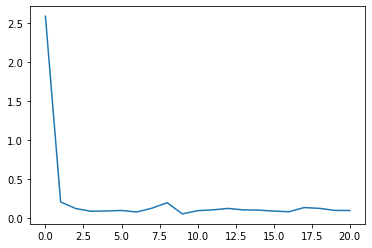

In [586]:
plt.plot(loss_history)
# plt.yscale("log")

In [587]:
model.get_weights()

[array([[ 0.27584875],
        [-1.8090013 ]], dtype=float32), array([0.01435786], dtype=float32)]

In [552]:
y0 = tf.cast([[[5.], [5.]]],tf.float32)
# model = md.oscillator_linear_control()
model = md.oscillator_NNcontrol()
optimizer = tf.train.MomentumOptimizer(learning_rate=3e-3, momentum=0.5)
# optimizer = tf.train.AdamOptimizer(learning_rate=1e-1)
loss_history = []

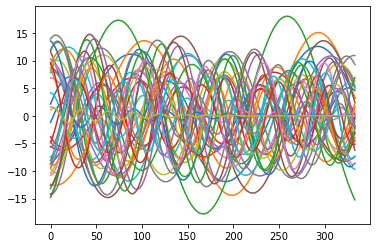

In [553]:
niters = 40
for iter in range (0,niters):
    y0 = tf.random_uniform([1,2,1], minval=-15.,maxval=15.)
    trajectory = tr.euler_opt(model,optimizer,y0,10.0,0.03)
    trajectory = np.concatenate(trajectory)
    loss = tf.reduce_mean(tf.math.abs(trajectory), axis=0) # Across time
    loss = tf.reduce_mean(loss, axis=0) # Across batches
    loss_history.append(loss[0])
    
    plt.plot(trajectory[:,0,0])
    
# model.get_weights()

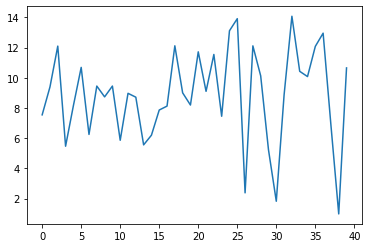

In [555]:
plt.plot(loss_history)